In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import numpy as np
import pandas as pd

n = 1000
x1 = np.random.randn(n)
x2 = np.random.rand(n)


df = pd.DataFrame(
    {'x1':x1, 'x2':x2}
)

df.head()

,x1,x2
0,-0.526567,0.469287
1,-1.028190,0.565757
2,-0.309286,0.782953
3,-1.092447,0.805920
4,-2.185525,0.719850


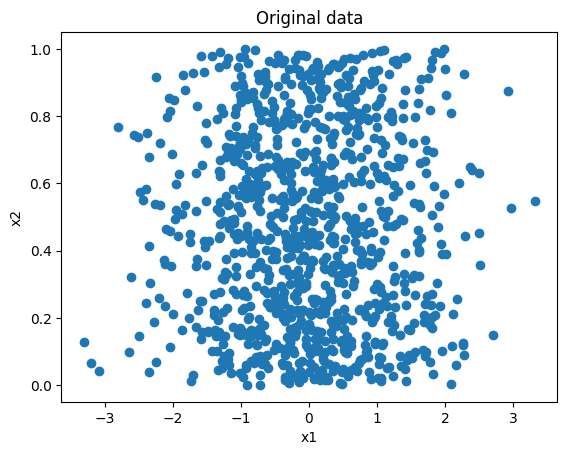

In [3]:
ax = plt.axes()
ax.scatter(df['x1'],df['x2'])
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Original data')
plt.show()

In [4]:
from statsmodels.nonparametric.kernel_density import KDEMultivariate
kde = KDEMultivariate(data=df, var_type='cc')

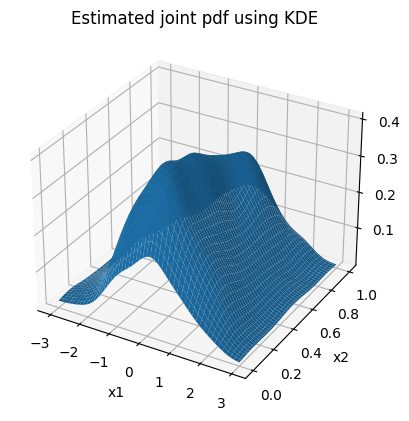

In [5]:
# plot estimated pdf
x=np.linspace(-3,3,100)
y=np.linspace(0,1,100)
X, Y = np.meshgrid(x,y)
z = np.array([kde.pdf([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = z.reshape(X.shape)

ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z)
plt.title('Estimated joint pdf using KDE')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [6]:
def rejection_sampling(
    kde: KDEMultivariate, rng: np.ndarray,
    cols: dict, M: int = 1, n: int = 1000, verbose: bool = False
) -> np.ndarray:
    '''
    rejection sampling

    Parameters
    ----------
    kde: statsmodel KDEMultivariate
        estimated kde
    rng: array_like
        range of variables in the form of a 2D array of (min, max)
    cols: dict
        dictionary of var names and their type.
    M: int, default = 1
        pdf max value
    n: int, default = 1000
        number of sample to generate
    verbose: bool, default = False
        whether to show verbose outputs 

    Returns
    -------
    2D array of samples        
    '''

    samp = []
    i = 0
    while (i<n):
        x = (
            np.random.rand(len(cols))
            * (np.max(rng, axis=-1) - np.min(rng, axis=-1))
            + np.min(rng, axis=-1)
        )

        # round categorical vars to the nearest int
        x = [
            x[i] if cols[c] == 'float'
            else round(x[i])
            for i,c in enumerate(cols)
        ]

        u = np.random.rand()

        verbose_interval = int(n/100)

        if u < kde.pdf(x) / M:
            samp.append(x)
            i += 1
            if verbose:
                if i % verbose_interval == 0:
                    print(
                        'sampled {0} out of {1} ({2}%)'.
                        format(i,n,round(i/n*100.0))
                    )

    return np.array(samp)

# define parameters required for rejection sampling
mins = np.array(df.min())
maxs = np.array(df.max())
rng = np.stack((mins,maxs), axis=1)

M = kde.pdf(df.median())

cols = {
    'x1': 'float',
    'x2': 'float'
}

# rejection sampling
samp = rejection_sampling(
    kde, rng, cols, M=M, n=2000
)

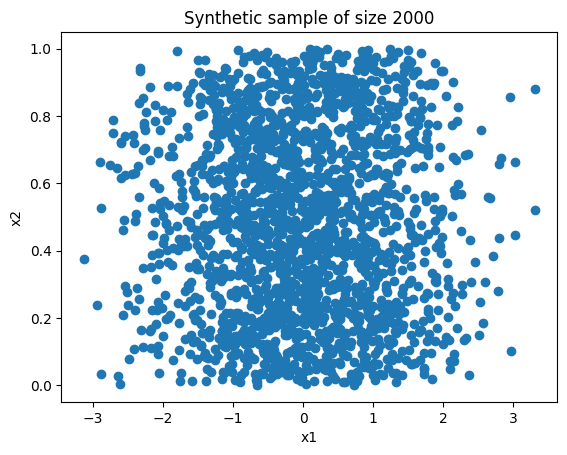

In [7]:
plt.scatter(samp[:,0], samp[:,1])
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Synthetic sample of size 2000')
plt.show()